In [1]:

# imports
import os
import sys
import types
import json

# figure size/format
fig_width = 7
fig_height = 5
fig_format = 'retina'
fig_dpi = 96

# matplotlib defaults / format
try:
  import matplotlib.pyplot as plt
  plt.rcParams['figure.figsize'] = (fig_width, fig_height)
  plt.rcParams['figure.dpi'] = fig_dpi
  plt.rcParams['savefig.dpi'] = fig_dpi
  from IPython.display import set_matplotlib_formats
  set_matplotlib_formats(fig_format)
except Exception:
  pass

# plotly use connected mode
try:
  import plotly.io as pio
  pio.renderers.default = "notebook_connected"
except Exception:
  pass

# enable pandas latex repr when targeting pdfs
try:
  import pandas as pd
  if fig_format == 'pdf':
    pd.set_option('display.latex.repr', True)
except Exception:
  pass



# output kernel dependencies
kernel_deps = dict()
for module in list(sys.modules.values()):
  # Some modules play games with sys.modules (e.g. email/__init__.py
  # in the standard library), and occasionally this can cause strange
  # failures in getattr.  Just ignore anything that's not an ordinary
  # module.
  if not isinstance(module, types.ModuleType):
    continue
  path = getattr(module, "__file__", None)
  if not path:
    continue
  if path.endswith(".pyc") or path.endswith(".pyo"):
    path = path[:-1]
  if not os.path.exists(path):
    continue
  kernel_deps[path] = os.stat(path).st_mtime
print(json.dumps(kernel_deps))

# set run_path if requested
if r'/home/hasan/Schreibtisch/projects/git_data/quarto_blog_hasan/posts/series/cv-foundations':
  os.chdir(r'/home/hasan/Schreibtisch/projects/git_data/quarto_blog_hasan/posts/series/cv-foundations')

# reset state
%reset

def ojs_define(**kwargs):
  import json
  try:
    # IPython 7.14 preferred import
    from IPython.display import display, HTML
  except:
    from IPython.core.display import display, HTML

  # do some minor magic for convenience when handling pandas
  # dataframes
  def convert(v):
    try:
      import pandas as pd
    except ModuleNotFoundError: # don't do the magic when pandas is not available
      return v
    if type(v) == pd.Series:
      v = pd.DataFrame(v)
    if type(v) == pd.DataFrame:
      j = json.loads(v.T.to_json(orient='split'))
      return dict((k,v) for (k,v) in zip(j["index"], j["data"]))
    else:
      return v
  
  v = dict(contents=list(dict(name=key, value=convert(value)) for (key, value) in kwargs.items()))
  display(HTML('<script type="ojs-define">' + json.dumps(v) + '</script>'), metadata=dict(ojs_define = True))
globals()["ojs_define"] = ojs_define


{"/home/hasan/miniconda3/lib/python3.12/importlib/_bootstrap.py": 1708118050.9241908, "/home/hasan/miniconda3/lib/python3.12/importlib/_bootstrap_external.py": 1708118050.9241908, "/home/hasan/miniconda3/lib/python3.12/zipimport.py": 1708118050.3201988, "/home/hasan/miniconda3/lib/python3.12/codecs.py": 1708118050.0762022, "/home/hasan/miniconda3/lib/python3.12/encodings/aliases.py": 1708118050.5121963, "/home/hasan/miniconda3/lib/python3.12/encodings/__init__.py": 1708118050.6041949, "/home/hasan/miniconda3/lib/python3.12/encodings/utf_8.py": 1708118050.7081935, "/home/hasan/miniconda3/lib/python3.12/abc.py": 1708118050.0562024, "/home/hasan/miniconda3/lib/python3.12/io.py": 1708118050.1442013, "/home/hasan/miniconda3/lib/python3.12/stat.py": 1708118050.2561998, "/home/hasan/miniconda3/lib/python3.12/_collections_abc.py": 1708118050.084202, "/home/hasan/miniconda3/lib/python3.12/genericpath.py": 1708118050.1242015, "/home/hasan/miniconda3/lib/python3.12/posixpath.py": 1708118050.19220

In [2]:
#| eval: true
import torch
import torch.nn as nn
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np

# Understanding ResNet's key innovation: skip connections
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        
        # Main path
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Skip connection (the magic!)
        self.skip = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        # Main path
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        
        # Add skip connection (this is the key!)
        out += self.skip(x)
        out = torch.relu(out)
        
        return out

# Create a simple ResNet-like model
class MiniResNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(MiniResNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, 7, 2, 3)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(3, 2, 1)
        
        # Stack residual blocks
        self.layer1 = self._make_layer(64, 64, 2, 1)
        self.layer2 = self._make_layer(64, 128, 2, 2)
        self.layer3 = self._make_layer(128, 256, 2, 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)
    
    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Compare with official ResNet
mini_resnet = MiniResNet(num_classes=1000)
official_resnet = models.resnet18(pretrained=True)

print("Mini ResNet:")
print(f"Parameters: {sum(p.numel() for p in mini_resnet.parameters()):,}")

print("\nOfficial ResNet-18:")
print(f"Parameters: {sum(p.numel() for p in official_resnet.parameters()):,}")

Mini ResNet:
Parameters: 3,042,024

Official ResNet-18:
Parameters: 11,689,512


/home/hasan/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/home/hasan/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.



In [3]:
#| eval: true
# EfficientNet's key insight: compound scaling
from torchvision.models import efficientnet_b0, efficientnet_b7

# Load different EfficientNet variants
efficient_b0 = efficientnet_b0(pretrained=True)
efficient_b7 = efficientnet_b7(pretrained=True)

def model_info(model, name):
    total_params = sum(p.numel() for p in model.parameters())
    return {
        'name': name,
        'parameters': total_params,
        'size_mb': total_params * 4 / (1024 * 1024)  # Rough estimate
    }

models_comparison = [
    model_info(efficient_b0, 'EfficientNet-B0'),
    model_info(efficient_b7, 'EfficientNet-B7'),
    model_info(official_resnet, 'ResNet-18')
]

print("Model Comparison:")
print("-" * 50)
for info in models_comparison:
    print(f"{info['name']:20} | {info['parameters']:>10,} params | {info['size_mb']:>6.1f} MB")

/home/hasan/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.



/home/hasan/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B7_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B7_Weights.DEFAULT` to get the most up-to-date weights.



Model Comparison:
--------------------------------------------------
EfficientNet-B0      |  5,288,548 params |   20.2 MB
EfficientNet-B7      | 66,347,960 params |  253.1 MB
ResNet-18            | 11,689,512 params |   44.6 MB


In [4]:
#| eval: true
class PatchEmbedding(nn.Module):
    """Convert image to sequence of patches"""
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        
        # Patch embedding using convolution
        self.projection = nn.Conv2d(
            in_channels, embed_dim, 
            kernel_size=patch_size, stride=patch_size
        )
    
    def forward(self, x):
        # x shape: (batch_size, channels, height, width)
        x = self.projection(x)  # (batch_size, embed_dim, num_patches_h, num_patches_w)
        x = x.flatten(2)        # (batch_size, embed_dim, num_patches)
        x = x.transpose(1, 2)   # (batch_size, num_patches, embed_dim)
        return x

class MultiHeadAttention(nn.Module):
    """Multi-head self-attention mechanism"""
    def __init__(self, embed_dim=768, num_heads=12):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.proj = nn.Linear(embed_dim, embed_dim)
    
    def forward(self, x):
        batch_size, seq_len, embed_dim = x.shape
        
        # Generate Q, K, V
        qkv = self.qkv(x).reshape(batch_size, seq_len, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # (3, batch_size, num_heads, seq_len, head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        # Compute attention
        attn = (q @ k.transpose(-2, -1)) / (self.head_dim ** 0.5)
        attn = torch.softmax(attn, dim=-1)
        
        # Apply attention to values
        out = (attn @ v).transpose(1, 2).reshape(batch_size, seq_len, embed_dim)
        out = self.proj(out)
        
        return out, attn

class TransformerBlock(nn.Module):
    """Single transformer encoder block"""
    def __init__(self, embed_dim=768, num_heads=12, mlp_ratio=4.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadAttention(embed_dim, num_heads)
        self.norm2 = nn.LayerNorm(embed_dim)
        
        # MLP
        mlp_hidden_dim = int(embed_dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_hidden_dim),
            nn.GELU(),
            nn.Linear(mlp_hidden_dim, embed_dim)
        )
    
    def forward(self, x):
        # Self-attention with residual connection
        attn_out, attn_weights = self.attn(self.norm1(x))
        x = x + attn_out
        
        # MLP with residual connection
        x = x + self.mlp(self.norm2(x))
        
        return x, attn_weights

class SimpleViT(nn.Module):
    """Simplified Vision Transformer"""
    def __init__(self, img_size=224, patch_size=16, num_classes=1000, 
                 embed_dim=768, depth=12, num_heads=12):
        super().__init__()
        
        # Patch embedding
        self.patch_embed = PatchEmbedding(img_size, patch_size, 3, embed_dim)
        num_patches = self.patch_embed.num_patches
        
        # Class token and position embedding
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        
        # Transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads) for _ in range(depth)
        ])
        
        # Classification head
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)
    
    def forward(self, x):
        batch_size = x.shape[0]
        
        # Patch embedding
        x = self.patch_embed(x)  # (batch_size, num_patches, embed_dim)
        
        # Add class token
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        
        # Add position embedding
        x = x + self.pos_embed
        
        # Apply transformer blocks
        attention_maps = []
        for block in self.blocks:
            x, attn = block(x)
            attention_maps.append(attn)
        
        # Classification
        x = self.norm(x)
        cls_token_final = x[:, 0]  # Use class token for classification
        out = self.head(cls_token_final)
        
        return out, attention_maps

# Create a simple ViT
simple_vit = SimpleViT(depth=6, num_heads=8)  # Smaller for demo
vit_params = sum(p.numel() for p in simple_vit.parameters())

print(f"Simple ViT parameters: {vit_params:,}")

# Test with dummy input
dummy_input = torch.randn(1, 3, 224, 224)
output, attention_maps = simple_vit(dummy_input)
print(f"Output shape: {output.shape}")
print(f"Number of attention maps: {len(attention_maps)}")

Simple ViT parameters: 44,040,424


Output shape: torch.Size([1, 1000])
Number of attention maps: 6


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.5162797..4.441542].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.5162797..4.441542].


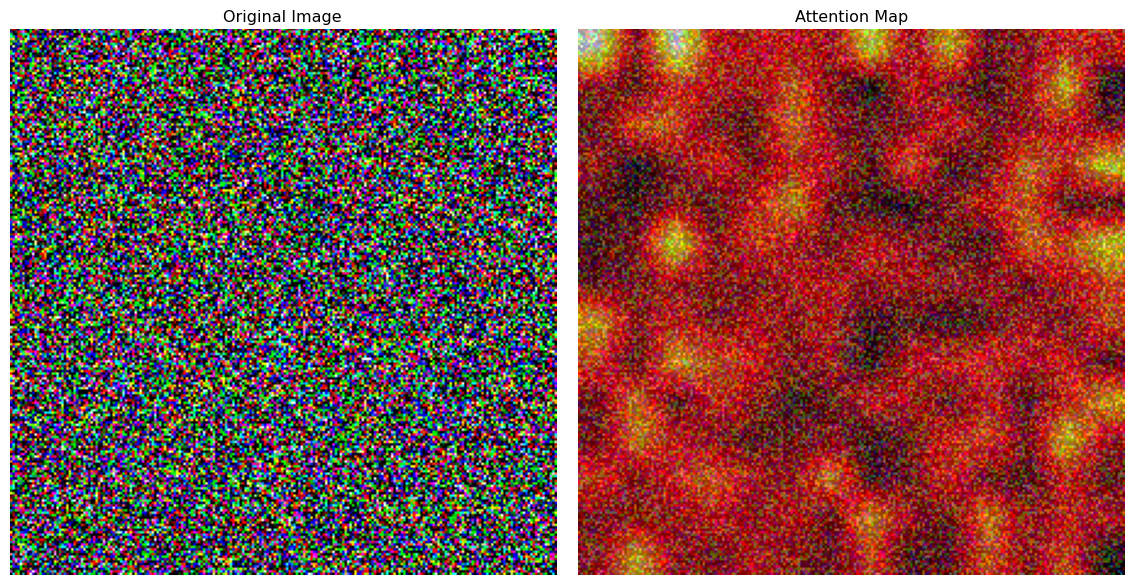

In [5]:
#| eval: true
def visualize_attention(image, attention_maps, patch_size=16):
    """Visualize what the vision transformer is looking at"""
    
    # Use attention from the last layer, first head
    attn = attention_maps[-1][0, 0]  # (seq_len, seq_len)
    
    # Get attention from class token to all patches
    cls_attn = attn[0, 1:]  # Exclude class token to class token attention
    
    # Reshape to spatial dimensions
    num_patches_per_side = int(len(cls_attn) ** 0.5)
    attn_map = cls_attn.reshape(num_patches_per_side, num_patches_per_side)
    
    # Resize to image size
    attn_map = torch.nn.functional.interpolate(
        attn_map.unsqueeze(0).unsqueeze(0),
        size=(224, 224),
        mode='bilinear'
    ).squeeze()
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(image.permute(1, 2, 0))
    plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(image.permute(1, 2, 0))
    plt.imshow(attn_map.detach().numpy(), alpha=0.6, cmap='hot')
    plt.title("Attention Map")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize attention (you would use a real image)
dummy_image = torch.randn(3, 224, 224)
visualize_attention(dummy_image, attention_maps)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.50, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loaded DINOv2 model: facebook/dinov2-base
Model parameters: 86,580,480
DINOv2 Feature Extraction Results:
Global features shape: torch.Size([1, 768])
Patch features shape: torch.Size([1, 256, 768])


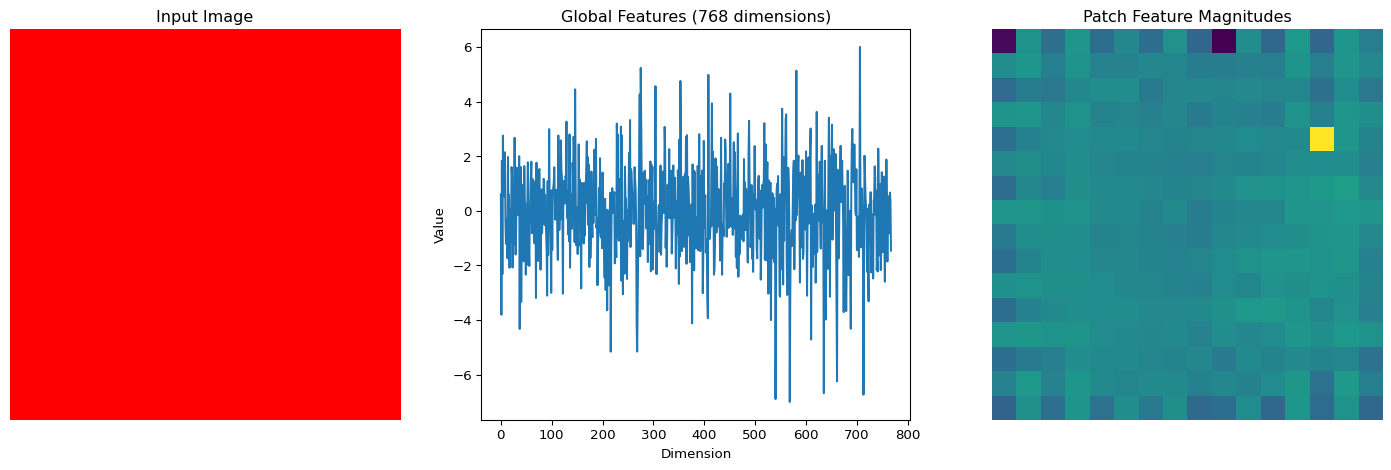

In [6]:
#| eval: true
# Install required packages
# !pip install transformers torch torchvision

from transformers import AutoImageProcessor, AutoModel
from PIL import Image
import requests

# Load DINOv2 model and processor
model_name = "facebook/dinov2-base"
processor = AutoImageProcessor.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

print(f"Loaded DINOv2 model: {model_name}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

def extract_dinov2_features(image_path_or_url):
    """Extract features using DINOv2"""
    
    # Load image
    if image_path_or_url.startswith('http'):
        image = Image.open(requests.get(image_path_or_url, stream=True).raw)
    else:
        image = Image.open(image_path_or_url)
    
    # Process image
    inputs = processor(images=image, return_tensors="pt")
    
    # Extract features
    with torch.no_grad():
        outputs = model(**inputs)
        features = outputs.last_hidden_state
        
        # Get CLS token (global image representation)
        cls_features = features[:, 0]  # Shape: (1, 768)
        
        # Get patch features (local representations)
        patch_features = features[:, 1:]  # Shape: (1, num_patches, 768)
    
    return {
        'cls_features': cls_features,
        'patch_features': patch_features,
        'image': image
    }

# Example usage
def demo_dinov2_features():
    """Demonstrate DINOv2 feature extraction"""
    
    # Create dummy image for demo (you would use real images)
    dummy_image = Image.new('RGB', (224, 224), color='red')
    
    # Save temporarily
    dummy_image.save('temp_image.jpg')
    
    # Extract features
    result = extract_dinov2_features('temp_image.jpg')
    
    print("DINOv2 Feature Extraction Results:")
    print(f"Global features shape: {result['cls_features'].shape}")
    print(f"Patch features shape: {result['patch_features'].shape}")
    
    # Visualize features
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(result['image'])
    plt.title("Input Image")
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.plot(result['cls_features'].squeeze().numpy())
    plt.title("Global Features (768 dimensions)")
    plt.xlabel("Dimension")
    plt.ylabel("Value")
    
    plt.subplot(1, 3, 3)
    # Visualize patch features as heatmap
    patch_norms = torch.norm(result['patch_features'].squeeze(), dim=1)
    patch_size = int(len(patch_norms) ** 0.5)
    patch_map = patch_norms.reshape(patch_size, patch_size)
    plt.imshow(patch_map.numpy(), cmap='viridis')
    plt.title("Patch Feature Magnitudes")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return result

demo_result = demo_dinov2_features()

Added image 'red_image' to database
Added image 'blue_image' to database


Added image 'green_image' to database
Added image 'yellow_image' to database


Added image 'purple_image' to database
Most similar images:
  red_image: 1.000
  yellow_image: 0.871
  green_image: 0.858


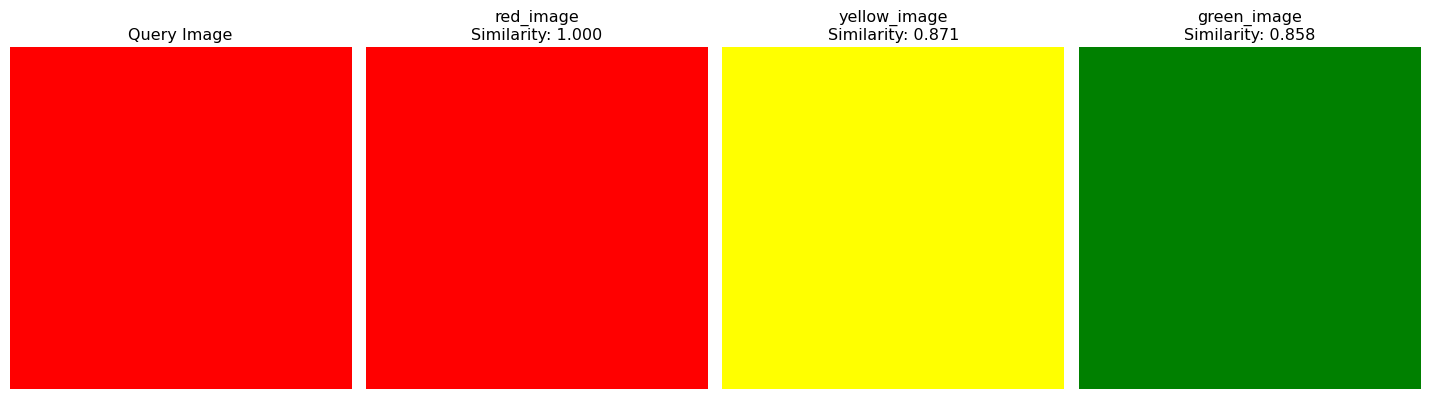

In [7]:
#| eval: true
class DINOv2SimilarityEngine:
    def __init__(self):
        self.processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base")
        self.model = AutoModel.from_pretrained("facebook/dinov2-base")
        self.model.eval()
        self.image_database = {}
    
    def extract_features(self, image):
        """Extract DINOv2 features from an image"""
        inputs = self.processor(images=image, return_tensors="pt")
        
        with torch.no_grad():
            outputs = self.model(**inputs)
            # Use CLS token as global image representation
            features = outputs.last_hidden_state[:, 0]
        
        return features
    
    def add_image(self, image_id, image):
        """Add an image to the database"""
        features = self.extract_features(image)
        self.image_database[image_id] = {
            'features': features,
            'image': image
        }
        print(f"Added image '{image_id}' to database")
    
    def find_similar_images(self, query_image, top_k=5):
        """Find most similar images in the database"""
        query_features = self.extract_features(query_image)
        
        similarities = {}
        
        for image_id, data in self.image_database.items():
            # Compute cosine similarity
            similarity = torch.cosine_similarity(
                query_features, data['features'], dim=1
            ).item()
            similarities[image_id] = similarity
        
        # Sort by similarity
        sorted_similarities = sorted(
            similarities.items(), key=lambda x: x[1], reverse=True
        )
        
        return sorted_similarities[:top_k]
    
    def visualize_results(self, query_image, similar_images):
        """Visualize similarity search results"""
        plt.figure(figsize=(15, 8))
        
        # Query image
        plt.subplot(2, len(similar_images) + 1, 1)
        plt.imshow(query_image)
        plt.title("Query Image")
        plt.axis('off')
        
        # Similar images
        for i, (image_id, similarity) in enumerate(similar_images):
            plt.subplot(2, len(similar_images) + 1, i + 2)
            plt.imshow(self.image_database[image_id]['image'])
            plt.title(f"{image_id}\nSimilarity: {similarity:.3f}")
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()

# Create similarity engine
similarity_engine = DINOv2SimilarityEngine()

# Demo with dummy images (you would use real images)
def demo_similarity_engine():
    """Demonstrate the similarity engine"""
    
    # Create some dummy images with different colors
    colors = ['red', 'blue', 'green', 'yellow', 'purple']
    
    for color in colors:
        dummy_img = Image.new('RGB', (224, 224), color=color)
        similarity_engine.add_image(f"{color}_image", dummy_img)
    
    # Query with a red image
    query_img = Image.new('RGB', (224, 224), color='red')
    
    # Find similar images
    similar = similarity_engine.find_similar_images(query_img, top_k=3)
    
    print("Most similar images:")
    for image_id, similarity in similar:
        print(f"  {image_id}: {similarity:.3f}")
    
    # Visualize results
    similarity_engine.visualize_results(query_img, similar)

demo_similarity_engine()

/home/hasan/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/home/hasan/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.

/home/hasan/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date w

/home/hasan/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.



Vision Models Comparison:
--------------------------------------------------------------------------------
ResNet-18       | 2015 | CNN             |     11.7 M |     44.6 MB
ResNet-50       | 2015 | CNN             |     25.6 M |     97.5 MB
EfficientNet-B0 | 2019 | CNN             |      5.3 M |     20.2 MB


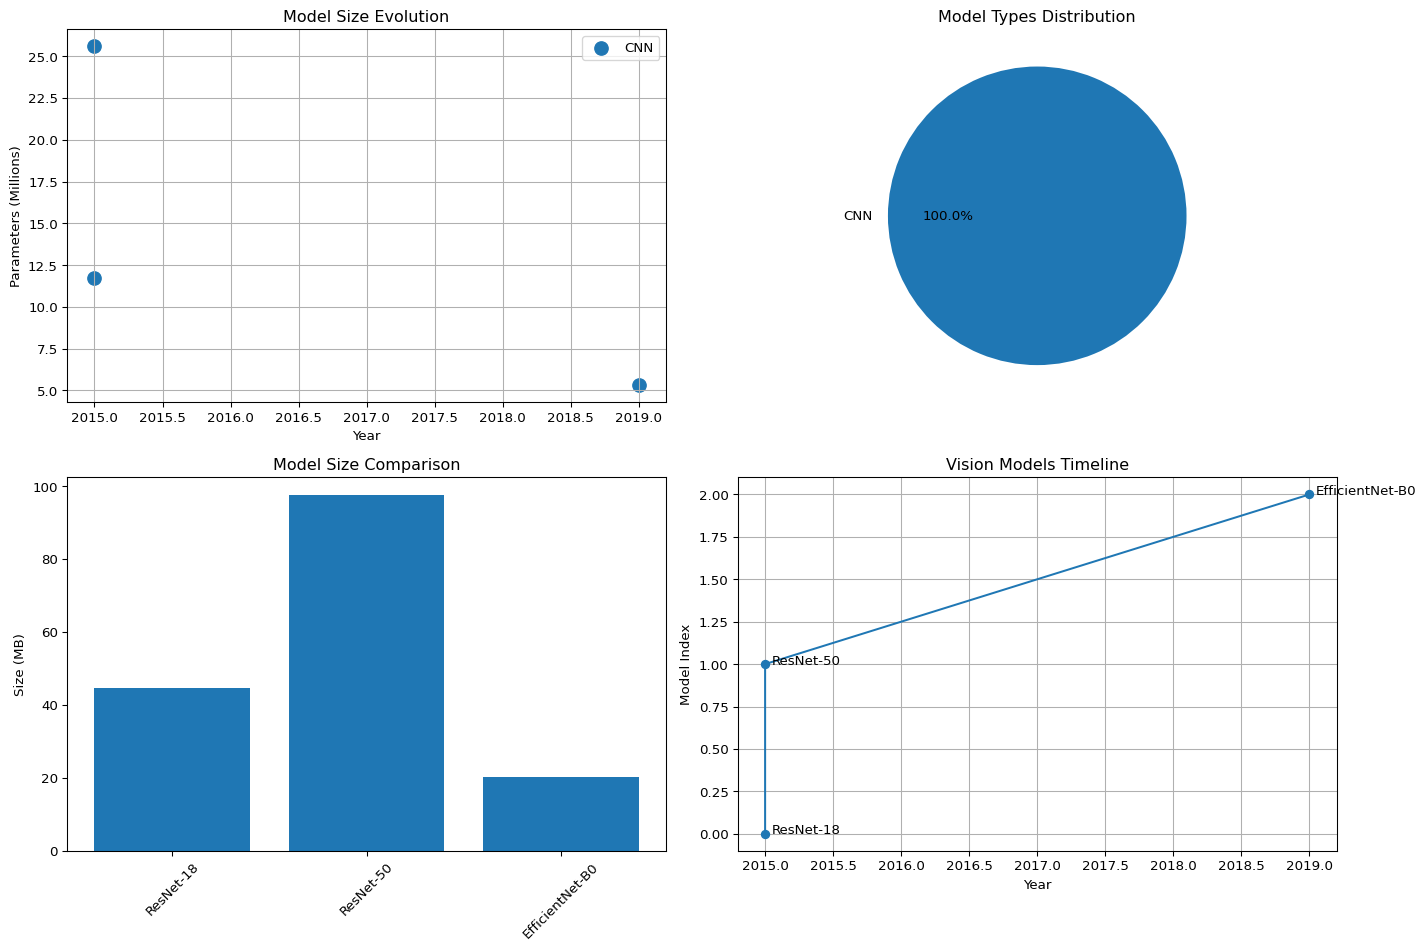

In [8]:
#| eval: true
class VisionModelComparison:
    def __init__(self):
        self.models = {
            'ResNet-18': models.resnet18(pretrained=True),
            'ResNet-50': models.resnet50(pretrained=True),
            'EfficientNet-B0': efficientnet_b0(pretrained=True),
            'ViT-Base': None,  # Would load from transformers
            'DINOv2-Base': None  # Already loaded above
        }
    
    def compare_models(self):
        """Compare different vision models"""
        comparison_data = []
        
        for name, model in self.models.items():
            if model is not None:
                params = sum(p.numel() for p in model.parameters())
                size_mb = params * 4 / (1024 * 1024)
                
                comparison_data.append({
                    'Model': name,
                    'Parameters (M)': f"{params / 1e6:.1f}",
                    'Size (MB)': f"{size_mb:.1f}",
                    'Year': self.get_year(name),
                    'Type': self.get_type(name)
                })
        
        return comparison_data
    
    def get_year(self, name):
        year_map = {
            'ResNet-18': 2015,
            'ResNet-50': 2015,
            'EfficientNet-B0': 2019,
            'ViT-Base': 2020,
            'DINOv2-Base': 2023
        }
        return year_map.get(name, 'Unknown')
    
    def get_type(self, name):
        if 'ResNet' in name or 'EfficientNet' in name:
            return 'CNN'
        elif 'ViT' in name:
            return 'Transformer'
        elif 'DINOv2' in name:
            return 'Foundation Model'
        return 'Unknown'
    
    def visualize_comparison(self, data):
        """Visualize model comparison"""
        import pandas as pd
        
        df = pd.DataFrame(data)
        
        plt.figure(figsize=(15, 10))
        
        # Parameters vs Year
        plt.subplot(2, 2, 1)
        for model_type in df['Type'].unique():
            subset = df[df['Type'] == model_type]
            plt.scatter(subset['Year'], subset['Parameters (M)'].astype(float), 
                       label=model_type, s=100)
        
        plt.xlabel('Year')
        plt.ylabel('Parameters (Millions)')
        plt.title('Model Size Evolution')
        plt.legend()
        plt.grid(True)
        
        # Model types distribution
        plt.subplot(2, 2, 2)
        type_counts = df['Type'].value_counts()
        plt.pie(type_counts.values, labels=type_counts.index, autopct='%1.1f%%')
        plt.title('Model Types Distribution')
        
        # Size comparison
        plt.subplot(2, 2, 3)
        plt.bar(df['Model'], df['Size (MB)'].astype(float))
        plt.xticks(rotation=45)
        plt.ylabel('Size (MB)')
        plt.title('Model Size Comparison')
        
        # Timeline
        plt.subplot(2, 2, 4)
        timeline_data = df.sort_values('Year')
        plt.plot(timeline_data['Year'], range(len(timeline_data)), 'o-')
        for i, (idx, row) in enumerate(timeline_data.iterrows()):
            plt.annotate(row['Model'], (row['Year'], i), 
                        xytext=(5, 0), textcoords='offset points')
        plt.xlabel('Year')
        plt.ylabel('Model Index')
        plt.title('Vision Models Timeline')
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()

# Run comparison
comparison = VisionModelComparison()
comparison_data = comparison.compare_models()

print("Vision Models Comparison:")
print("-" * 80)
for data in comparison_data:
    print(f"{data['Model']:15} | {data['Year']} | {data['Type']:15} | "
          f"{data['Parameters (M)']:>8} M | {data['Size (MB)']:>8} MB")

comparison.visualize_comparison(comparison_data)

In [9]:
#| eval: true
class ModernVisionPipeline:
    def __init__(self):
        # Load multiple models for different tasks
        self.classification_model = models.resnet50(pretrained=True)
        self.feature_extractor = None  # DINOv2 model
        self.similarity_engine = DINOv2SimilarityEngine()
    
    def classify_image(self, image):
        """Classify image using ResNet"""
        # Your implementation here
        pass
    
    def extract_features(self, image):
        """Extract features using DINOv2"""
        # Your implementation here
        pass
    
    def find_similar_images(self, query_image, database):
        """Find similar images using DINOv2 features"""
        # Your implementation here
        pass
    
    def analyze_image(self, image):
        """Complete image analysis pipeline"""
        results = {
            'classification': self.classify_image(image),
            'features': self.extract_features(image),
            'similar_images': self.find_similar_images(image, self.image_database)
        }
        return results

# Build your pipeline!
pipeline = ModernVisionPipeline()

/home/hasan/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/home/hasan/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.

